# Gaussian generative models for handwritten digit classification

Recall that the 1-NN classifier yielded a 3.09% test error rate on the MNIST data set of handwritten digits. We will now see that a Gaussian generative model does almost as well, while being significantly faster and more compact.

## 1. Set up notebook and load in data

As usual, we start by importing the required packages and data. For this notebook we will be using the *entire* `MNIST` dataset. The code below defines some helper functions that will load `MNIST` onto your computer.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import gzip, os
import numpy as np
import pandas as pd
import multiprocessing as mp 
from scipy.stats import multivariate_normal
from sklearn.model_selection import KFold

from urllib.request import urlretrieve

In [2]:
# Function that downloads a specified MNIST data file from Yann Le Cun's website
def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

# Invokes download() if necessary, then reads in images
def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1,784)
    return data

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

Now load in the training set and test set

In [3]:
## Load the training set
train_data = load_mnist_images('train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')

## Load the testing set
test_data = load_mnist_images('t10k-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

The function **displaychar** shows a single MNIST digit. To do this, it first has to reshape the 784-dimensional vector into a 28x28 image.

In [4]:
def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

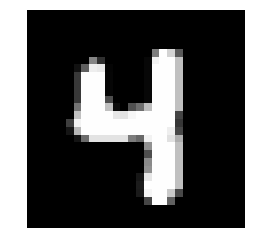

In [5]:
displaychar(train_data[58])

The training set consists of 60,000 images. Thus `train_data` should be a 60000x784 array while `train_labels` should be 60000x1. Let's check.

In [6]:
train_data.shape, train_labels.shape

((60000, 784), (60000,))

## 2. Fit a Gaussian generative model to the training data

**<font color="magenta">For you to do:</font>** Define a function, **fit_generative_model**, that takes as input a training set (data `x` and labels `y`) and fits a Gaussian generative model to it. It should return the parameters of this generative model; for each label `j = 0,1,...,9`, we have:
* `pi[j]`: the frequency of that label
* `mu[j]`: the 784-dimensional mean vector
* `sigma[j]`: the 784x784 covariance matrix

This means that `pi` is 10x1, `mu` is 10x784, and `sigma` is 10x784x784.

We have already seen how to fit a Gaussian generative model in the Winery example, but now there is an added ingredient. <font color="magenta">The empirical covariances are very likely to be singular (or close to singular), which means that we won't be able to do calculations with them</font>. Thus it is important to **regularize** these matrices. The standard way of doing this is to add `cI` to them, where `c` is some constant and `I` is the 784-dimensional identity matrix. (To put it another way, we compute the empirical covariances and then increase their diagonal entries by some constant `c`.)

This modification is guaranteed to yield covariance matrices that are non-singular, for any `c > 0`, no matter how small. But this doesn't mean that we should make `c` as small as possible. Indeed, `c` is now a parameter, and by setting it appropriately, we can improve the performance of the model. We will study **regularization** in greater detail over the coming weeks.

Your routine needs to choose a good setting of `c`. Crucially, this needs to be done using the training set alone. So you might try setting aside part of the training set as a validation set, or using some kind of cross-validation.

In [7]:
def fit_generative_model(x,y,c):
    k = 10  # labels 0,1,...,k-1
    d = (x.shape)[1]  # number of features
    mu = np.zeros((k,d))
    sigma = np.zeros((k,d,d))
    pi = np.zeros(k)
    ###
    ### Your code goes here
    ###
    for label in range(0,k):
        indices = (y == label)
        mu[label] = np.mean(x[indices,:], axis=0)
        sigma[label] = np.cov(x[indices,:], rowvar=0, bias=1) +  c * np.identity(d)
        pi[label] = float(sum(indices))/float(len(y))
    
    # Halt and return parameters
    return mu, sigma, pi

Okay, let's try out your function. In particular, we will use **displaychar** to visualize the means of the Gaussians for the first three digits. You can try the other digits on your own.

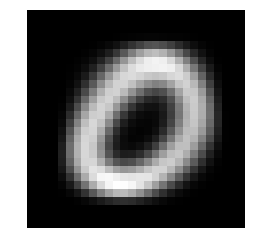

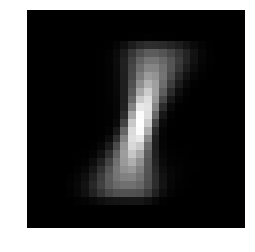

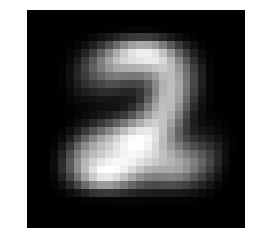

In [8]:
mu, sigma, pi = fit_generative_model(train_data, train_labels, 1)
displaychar(mu[0])
displaychar(mu[1])
displaychar(mu[2])

## 3. Make predictions on test data

Now let's see how many errors your model makes on the test set.

In [9]:
def test_model(mu, sigma, pi, t_data, t_labels):
    # Compute log Pr(label|image) for each [test image,label] pair.
    k=10
    score = np.zeros((len(t_labels),k))
    for label in range(0,k):
        rv = multivariate_normal(mean=mu[label], cov=sigma[label])
        for i in range(0,len(t_labels)):
           score[i,label] = np.log(pi[label]) + rv.logpdf(t_data[i,:])
    predictions = np.argmax(score, axis=1)
    # Finally, tally up score
    errors = np.sum(predictions != t_labels)
    return errors
    #print ("Your model makes " + str(errors) + " errors out of 10000")

In [10]:
test_model(mu, sigma, pi, test_data, test_labels)

1588

## 4. Quick exercises

*You will need to answer variants of these questions as part of this week's assignment*.

<font color="magenta">Exercise 1:</font> What happens if you do not regularize the covariance matrices?

<font color="magenta">Exercise 2:</font> What happens if you set the value of `c` too high, for instance to one billion? Do you understand why this happens?

<font color="magenta">Exercise 3:</font> What value of c did you end up using? How many errors did your model make on the training set?

In [11]:
# Split train data in test and train set
perm = np.random.permutation(train_data.shape[0])
train_test_data = train_data[perm[:10000]]
train_test_labels = train_labels[perm[:10000]]
train_train_data = train_data[perm[10001:]]
train_train_labels = train_labels[perm[10001:]]


def test_kfold(x, y, k, c):
    kf = KFold(n_splits=k, shuffle=True)
    errors = []
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        mu, sigma, pi = fit_generative_model(x_train, y_train, c)
        errors.append(test_model(mu, sigma, pi, x_test, y_test))
    return np.sum(errors)/k

In [12]:
%%time
for c in range(3500, 4501, 100):
    error = test_kfold(train_data, train_labels, 5, c)
    print('c: %s; error:%s' % (c, error))

c: 3500; error:573.8


KeyboardInterrupt: 

In [30]:
def plot_errors(c_list):
    errors = {}
    for c in c_list:
        error = test_kfold(train_data, train_labels, 10, c)
        errors[c] = error
        print('c: %s; error:%s' % (c, error))

    err = pd.DataFrame.from_dict(errors, orient='index')
    err.plot()

c: 1000; error:318.0
c: 1200; error:308.3
c: 1400; error:301.7
c: 1600; error:297.3
c: 1800; error:293.9
c: 2000; error:290.9
c: 2200; error:288.5
c: 2400; error:286.7
c: 2600; error:287.2
c: 2800; error:286.5
c: 3000; error:286.4
c: 3200; error:287.2
c: 3400; error:286.0
c: 3600; error:285.6
c: 3800; error:286.9
c: 4000; error:288.5
c: 4200; error:287.1
c: 4400; error:287.0
c: 4600; error:288.3
c: 4800; error:291.3
c: 5000; error:291.6


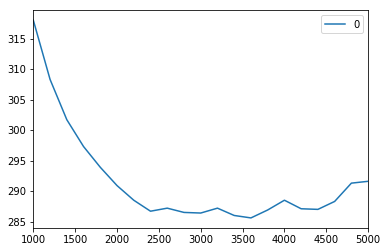

In [34]:
plot_errors(range(1000, 5001, 200))

In [33]:
for c in range(1000, 5001, 200):
    mu, sigma, pi = fit_generative_model(train_data, train_labels, c)
    error = test_model(mu, sigma, pi, test_data, test_labels)
    print('c: %s; error: %s' % (c, error))

c: 1000; error: 489
c: 1200; error: 470
c: 1400; error: 456
c: 1600; error: 444
c: 1800; error: 440
c: 2000; error: 437
c: 2200; error: 436
c: 2400; error: 435
c: 2600; error: 430
c: 2800; error: 428
c: 3000; error: 435
c: 3200; error: 436
c: 3400; error: 435
c: 3600; error: 436
c: 3800; error: 434
c: 4000; error: 431
c: 4200; error: 433
c: 4400; error: 434
c: 4600; error: 437
c: 4800; error: 438
c: 5000; error: 438


<font color="magenta">If you have the time</font>: We have talked about using the same regularization constant `c` for all ten classes. What about using a different value of `c` for each class? How would you go about choosing these? Can you get better performance in this way?

In [13]:
np.__config__.show()

blas_mkl_info:
    libraries = ['mkl_intel_lp64', 'mkl_intel_thread', 'mkl_core', 'iomp5', 'pthread']
    library_dirs = ['/Users/Lukas/anaconda/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/Lukas/anaconda/include']
blas_opt_info:
    libraries = ['mkl_intel_lp64', 'mkl_intel_thread', 'mkl_core', 'iomp5', 'pthread']
    library_dirs = ['/Users/Lukas/anaconda/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/Lukas/anaconda/include']
lapack_mkl_info:
    libraries = ['mkl_intel_lp64', 'mkl_intel_thread', 'mkl_core', 'iomp5', 'pthread']
    library_dirs = ['/Users/Lukas/anaconda/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/Lukas/anaconda/include']
lapack_opt_info:
    libraries = ['mkl_intel_lp64', 'mkl_intel_thread', 'mkl_core', 'iomp5', 'pthread']
    library_dirs = ['/Users/Lukas/anaconda/lib']
    define_macros = [('SCIPY_MKL_H'